Company XYZ is an Online Travel Agent, such as Expedia, Booking.com, etc.
They store their data in JSON files. Each row in the json shows all different cities which have
been searched for by a user within the same session (as well as some other info about the user).
That is, if I go to company XYZ site and look for hotels in NY and SF within the same session,
the corresponding JSON row will show my user id, some basic info about me and the two cities

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from collections import Counter
from sklearn.preprocessing import normalize
# for test git

In [2]:
# open json file
with open('city_searches.json', 'r') as f:
    json_data = json.load(f)

In [3]:
json_data

[{'session_id': ['D258NVMV202LS'],
  'unix_timestamp': [1442640552],
  'cities': ['San Jose CA, Montreal QC'],
  'user': [[{'user_id': 5749,
     'joining_date': '2015-04-02',
     'country': 'FR'}]]},
 {'session_id': ['TDG10UKG7I4LR'],
  'unix_timestamp': [1432110137],
  'cities': ['New York NY'],
  'user': [[{'user_id': 10716,
     'joining_date': '2015-03-30',
     'country': 'DE'}]]},
 {'session_id': ['OH4ZDIGN9BLQS'],
  'unix_timestamp': [1437049311],
  'cities': ['Montreal QC, Quebec QC'],
  'user': [[{'user_id': 2941, 'joining_date': '2015-03-16', 'country': ''}]]},
 {'session_id': ['CWHIAYKQ7RA28'],
  'unix_timestamp': [1432215908],
  'cities': ['Chicago IL'],
  'user': [[{'user_id': 2164,
     'joining_date': '2015-03-27',
     'country': 'FR'}]]},
 {'session_id': ['GI8GZJAWAC80P'],
  'unix_timestamp': [1443556226],
  'cities': ['Toronto ON, Houston TX'],
  'user': [[{'user_id': 10493,
     'joining_date': '2015-03-31',
     'country': 'US'}]]},
 {'session_id': ['NRMA4TM621WRD

In [4]:
def parse_json(data):
    # create empty list first
    session_id = []
    unix_timestamp = []
    cities = []
    user = []
    joining_date = []
    country = []
    
    # insert data from each row of json file to lists
    for i in data:
        session_id.append(i['session_id'][0])
        unix_timestamp.append(i['unix_timestamp'][0])
        cities.append(i['cities'][0])
        user.append(i['user'][0][0]['user_id'])
        joining_date.append(i['user'][0][0]['joining_date'])
        country.append(i['user'][0][0]['country'])

    # create a DataFrame
    temp = {'session_id': session_id, 'unix_timestamp': unix_timestamp, 'cities': cities, 'user': user, 
            'joining_date': joining_date, 'country': country}
    df_result = pd.DataFrame(temp)
    return df_result

In [5]:
df = parse_json(json_data)

In [6]:
df['joining_date'] = pd.to_datetime(df['joining_date'])
df.head()

,session_id,unix_timestamp,cities,user,joining_date,country
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US


In [7]:
# Converting unix timestamp string to readable date
df['session_time'] = pd.to_datetime(df['unix_timestamp'], unit='s')

# Drop the "unix_timestamp" column
df = df.drop(labels='unix_timestamp', axis=1)

# Task01:
* There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?

In [8]:
df['country'].value_counts()

US    3772
UK    3754
DE    3741
      2769
FR    2341
IT    1843
ES    1802
Name: country, dtype: int64

In [9]:
set(df['country'])

{'', 'DE', 'ES', 'FR', 'IT', 'UK', 'US'}

In [10]:
# slice out the hour from session_time
df['session_hour'] = df['session_time'].apply(lambda x: x.hour)

df

,session_id,cities,user,joining_date,country,session_time,session_hour
0,D258NVMV202LS,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5
1,TDG10UKG7I4LR,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8
2,OH4ZDIGN9BLQS,"Montreal QC, Quebec QC",2941,2015-03-16,,2015-07-16 12:21:51,12
3,CWHIAYKQ7RA28,Chicago IL,2164,2015-03-27,FR,2015-05-21 13:45:08,13
4,GI8GZJAWAC80P,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19
...,...,...,...,...,...,...,...
20017,LGO21SOLIFVIA,Phoenix AZ,2636,2015-03-17,US,2015-07-02 18:18:00,18
20018,GQ4W7LU56MHXK,OTTAWA ON,8144,2015-03-08,UK,2015-07-10 16:19:14,16
20019,N2FQ84QXOBFQM,Indianapolis IN,4816,2015-03-29,DE,2015-03-29 10:35:45,10
20020,54RKP04D2OGDB,Chicago IL,6812,2015-03-09,ES,2015-09-14 12:49:03,12


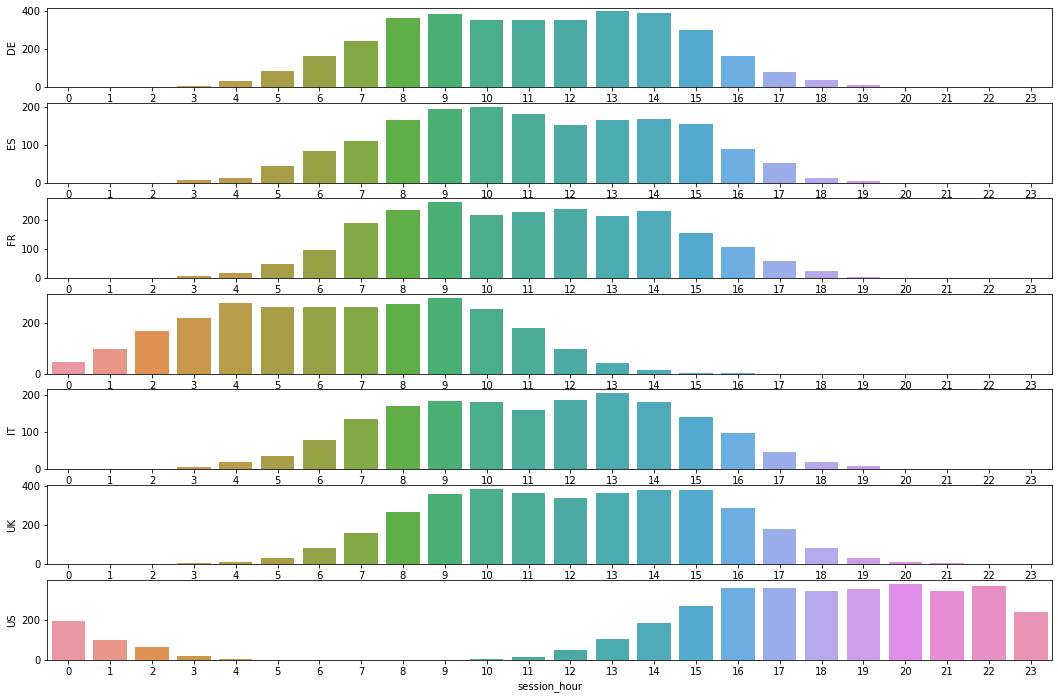

In [11]:
# plot
country_list = ['DE', 'ES', 'FR', '', 'IT', 'UK', 'US']
order = list(range(0,24))

fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(18,12))
for i in range(len(country_list)):
    sns.countplot(x='session_hour', data=df[df['country'] == country_list[i]], ax=ax[i],order=order)
    ax[i].set_ylabel(country_list[i])
    
plt.show()

*  That country's peak search time is around 12 hours difference with United States, and around 5 hours difference with Europe. Based on Time zone, it seems that this missing country is in Asia. Maybe  **China** , **South Korea**, and **Japan**.

# Task02:
* For each city, find the most likely city to be also searched for within the same session.

In [12]:
# split the cities by ", "
df['cities'] = df.cities.str.split(', ')

# find how many times that a city has been searched by a user
def count_cities(df):
    c = Counter(city for cities in df.cities for city in cities)
    return pd.Series(c)
searchcity_by_user = df.groupby("user").apply(count_cities).unstack(fill_value=0)

In [13]:
# pivot the dataframe
searchcity_by_user = searchcity_by_user.transpose()
searchcity_by_user

user,1,2,4,6,7,8,9,10,11,12,...,10989,10990,10991,10992,10993,10995,10996,10998,10999,11000
Anaheim CA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arlington TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atlanta GA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Austin TX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bakersfield CA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Victoria BC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Virginia Beach VA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WASHINGTON DC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Wichita KS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# make each row unit-norm, then dot-product is equivalent to cosine similarity
searchcity_by_user_normed = normalize(searchcity_by_user,axis=1)

In [15]:
# searchcity_by_user_normed matrix multiply by searchcity_by_user_normed.T matrix (= pivoted searchcity_by_user_normed matrix)
city_similarity = searchcity_by_user_normed.dot(searchcity_by_user_normed.T)

# covert it to a dataframe
city_similarity = pd.DataFrame(city_similarity,
                               index = searchcity_by_user.index,
                               columns = searchcity_by_user.index)
city_similarity.head()

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
Anaheim CA,1.000000,0.034157,0.024398,0.022908,0.057505,0.027524,0.00000,0.017528,0.009858,0.024836,...,0.005832,0.082593,0.015430,0.000000,0.043104,0.021289,0.018898,0.006855,0.024398,0.021277
Arlington TX,0.034157,1.000000,0.016667,0.245171,0.015713,0.016116,0.00000,0.023947,0.033672,0.027146,...,0.007968,0.041841,0.021082,0.073030,0.044169,0.011635,0.000000,0.000000,0.066667,0.000000
Atlanta GA,0.024398,0.016667,1.000000,0.000000,0.039284,0.000000,0.46291,0.000000,0.000000,0.008483,...,0.019920,0.009509,0.000000,0.000000,0.015775,0.000000,0.000000,0.000000,0.000000,0.000000
Austin TX,0.022908,0.245171,0.000000,1.000000,0.012295,0.016814,0.00000,0.014053,0.042155,0.026551,...,0.006235,0.051589,0.000000,0.028571,0.052664,0.027311,0.000000,0.007328,0.000000,0.007582
Bakersfield CA,0.057505,0.015713,0.039284,0.012295,1.000000,0.012662,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.026896,0.000000,0.000000,0.004957,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
### find top K most similar of each city
def most_similar(s,topk):
    # [0] must be itself
    similar_ones = s.sort_values(ascending=False)[1:topk+1].index.values
    return pd.Series(similar_ones,index = ["similar#{}".format(i) for i in range(1,topk+1)])

most_similar_cities = city_similarity.apply(most_similar,topk=1,axis=1)

In [17]:
most_similar_cities

,similar#1
Anaheim CA,Santa Ana CA
Arlington TX,Fort Worth TX
Atlanta GA,Birmingham AL
Austin TX,San Antonio TX
Bakersfield CA,Fresno CA
...,...
Victoria BC,Seattle WA
Virginia Beach VA,Chesapeake VA
WASHINGTON DC,Baltimore MD
Wichita KS,Lincoln NE


* Above cities are the most likely city to be also searched for within the same session.

# Task03:
* Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. That is, a user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way

In [18]:
df_for_distance = parse_json(json_data)
df_for_distance

,session_id,unix_timestamp,cities,user,joining_date,country
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US
...,...,...,...,...,...,...
20017,LGO21SOLIFVIA,1435861080,Phoenix AZ,2636,2015-03-17,US
20018,GQ4W7LU56MHXK,1436545154,OTTAWA ON,8144,2015-03-08,UK
20019,N2FQ84QXOBFQM,1427625345,Indianapolis IN,4816,2015-03-29,DE
20020,54RKP04D2OGDB,1442234943,Chicago IL,6812,2015-03-09,ES


In [19]:
def search_distance(cities):
    cities = cities.split(', ')
    
    if len(cities) == 1:
        return 0  # user only search one city, distance 0
    
    distance = 0
    for i in range(len(cities) - 1):
        city1 = cities[i]
        for j in range(i + 1, len(cities)):
            city2 = cities[j]
            distance += city_similarity.loc[city1, city2]
            
    return distance / len(cities)

# calculate distance
df_for_distance['distance'] = df_for_distance['cities'].apply(search_distance)

C:\Users\14152\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


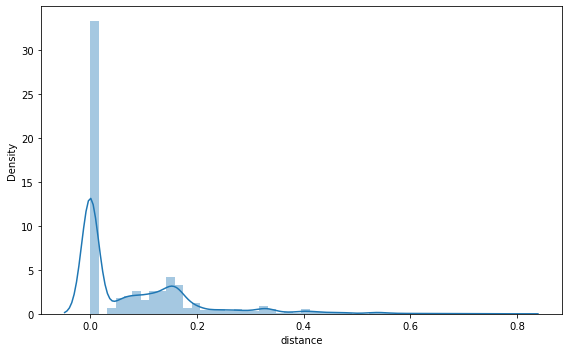

In [20]:
# visualization
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(df_for_distance['distance'], ax=ax, bins=50)
plt.tight_layout()
plt.show()

* It seems that we can set some threshold to cut the search distance such that any search that is above the threshold are assumed to be the search with low intent

In [21]:
# I choose 0.5 as the cutoff of the distance
dist_cutoff = 0.5
dist = df_for_distance['distance']
print(f'When distance cutoff is {dist_cutoff}, the percentage of low intent search: {(dist>dist_cutoff).mean() * 100:.2f}%')

When distance cutoff is 0.5, the percentage of low intent search: 1.14%


In [22]:
low_intent_search = df_for_distance.loc[dist>dist_cutoff,:]
low_intent_search

,session_id,unix_timestamp,cities,user,joining_date,country,distance
78,64KNNSKODFYMH,1440861017,"Los Angeles CA, Anaheim CA, Riverside CA, Sant...",1384,2015-03-02,DE,0.630772
82,ET4WUPLRP4RKR,1435391398,"New York NY, Philadelphia PA, Jersey City NJ, ...",10713,2015-03-30,UK,0.542096
161,ELVVH8B2VOOCA,1442923420,"Jacksonville FL, Miami FL, Hialeah FL, Saint P...",3689,2015-03-02,UK,0.617561
432,J4SH0ZKSGDMLN,1436358350,"New York NY, Philadelphia PA, Jersey City NJ, ...",9876,2015-03-10,IT,0.614096
440,5270DH3VCZ4IZ,1430376022,"San Diego CA, Anaheim CA, Santa Ana CA, Long B...",5573,2015-03-22,IT,0.584425
...,...,...,...,...,...,...,...
19365,XJ7MV4AR4LQCL,1428070724,"Los Angeles CA, Anaheim CA, Long Beach CA, San...",10231,2015-03-19,US,0.526812
19417,P6DSC0TOABITT,1440673417,"Indianapolis IN, Cincinnati OH, Louisville KY,...",9429,2015-03-30,ES,0.569318
19566,I9HDFJM9F6I1J,1436426859,"New York NY, Jersey City NJ, Newark NJ, Philad...",5490,2015-03-06,,0.542096
19871,C2ZK08DBE6DUT,1429694600,"Indianapolis IN, Cincinnati OH, Lexington KY, ...",10367,2015-03-17,DE,0.569318


### We can assume above searches as low intent searches 